<a href="https://colab.research.google.com/github/mostafaghadimi/IEEE-HandsOn/blob/master/Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img src = 'http://ieeesb.ut.ac.ir/wp-content/uploads/2017/07/UTIEEESB-e1499240766700.png' alt="IEEE-Logo" width="200" height="80" align="left">

<img src = 'https://ece.ut.ac.ir/cict-theme/images/footer-logo.png' alt="Tehran-University-Logo" width="100" height="120" align="right">

<h1 align=center><font size=6> <b><i>Regression<br>Hands-on Session</i></font></h1>

*Prepared by Mahdi Nikdan, Mostafa Ghadimi and Hossein Zakerinia*

# **Warm up**

> In this section, we are going to work with a simple dataset using `pandas`, `numpy`, `matplotlib` and `scikit learn` libraries.


## *Setup*

In [0]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Useful for many scientific computing in Python
import numpy as np

# Provides a way of using operating system dependent functionality. 
import os

# Primary data structure library 
import pandas as pd

# To plot pretty figures
import matplotlib.pyplot as plt
%matplotlib inline

# To make this notebook's output stable across runs
np.random.seed(1)
import random
random.seed(1)

# A progress bar library
from tqdm import tqdm

# A data visualization library
import seaborn as sns

# A python library for machine learning
from sklearn.linear_model.logistic import _logistic_loss
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge, Lasso, ElasticNet
from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.datasets import load_iris

In [0]:
def save_fig(fig_id, tight_layout=True):
    path = os.path.join(fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

## **Load Dataset**

### *Download Dataset*

Automating the process of fetching the data is also useful if you need to install the dataset on multiple machines. 

In [0]:
!wget https://raw.githubusercontent.com/mostafaghadimi/IEEE-HandsOn/master/resources/simple_dataset.csv

--2019-12-23 14:52:08--  https://raw.githubusercontent.com/mostafaghadimi/IEEE-HandsOn/master/resources/simple_dataset.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4185 (4.1K) [text/plain]
Saving to: ‘simple_dataset.csv’

simple_dataset.csv  100%[===================>]   4.09K  --.-KB/s    in 0s      

2019-12-23 14:52:13 (43.1 MB/s) - ‘simple_dataset.csv’ saved [4185/4185]



### *Loading Dataset using Pandas*

Following cell creates DataFrame object containing all the data.

In [0]:
simple_dataset = pd.read_csv('simple_dataset.csv', index_col=0)

Let’s take a look at the top five rows using the DataFrame’s `head()` method.

In [0]:
simple_dataset.head()

,x,y
0,-1.973154,-19.044627
1,-0.182215,-1.947762
2,1.313515,-7.991518
3,-1.918774,-19.952561
4,-2.299572,-28.573069


The `info()` method is useful to get a quick description of the data, in particular the total number of rows, and each attribute’s type and number of non-null values 

In [0]:
simple_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100 entries, 0 to 99
Data columns (total 2 columns):
x    100 non-null float64
y    100 non-null float64
dtypes: float64(2)
memory usage: 2.3 KB


Let’s look at the other fields. The `describe()` method shows a summary of the numerical attributes.

In [0]:
simple_dataset.describe()

,x,y
count,100.000000,100.000000
mean,-0.128093,-5.726619
std,1.065942,6.247443
min,-2.517031,-34.661416
25%,-0.902279,-7.837568
50%,-0.060251,-3.713732
75%,0.592841,-2.312035
max,2.808193,4.834760


The `count, mean, min`, and `max` rows are self-explanatory. Note that the null values are ignored. The `std` row shows the standard deviation (which measures how dispersed the values are). The $25\%$, $50\%$, and $75\%$ rows show the corresponding percentiles:

* a percentile indicates the value below which a given percentage of observations in a group of observations falls.

### *Split Train and Test Data*

It may sound strange to voluntarily set aside part of the data at this stage. After all, you have only taken a quick glance at the data, and surely you should learn a whole lot more about it before you decide what algorithms to use, right? This is true, but your brain is an amazing pattern detection system, which means that it is highly prone to **overfitting**:
* if you look at the test set, you may stumble upon some seemingly interesting pattern in the test data that leads you to select a particular kind of Machine Learning model.

When you estimate the generalization error using the test set, your estimate will be too optimistic and you will launch a system that will not perform as well as expected. This is called data snooping bias. Creating a test set is theoretically quite simple: just pick some instances randomly, typically $20\%$ of the dataset, and set them aside

In [0]:
# test_size: the proportion of the dataset to include in the test split
X_train_simple, X_test_simple, y_train_simple, y_test_simple = train_test_split(simple_dataset['x'], simple_dataset['y'], test_size = .2)

# sklearn takes a 2D argument for training
X_train_simple = np.expand_dims(X_train_simple, axis=1)
X_test_simple = np.expand_dims(X_test_simple, axis=1)

X_train_simple.shape, y_train_simple.shape, X_test_simple.shape, y_test_simple.shape

((80, 1), (80,), (20, 1), (20,))

## **Declare Regression Functions**

### *Scikit-Learn Design*

Scikit-Learn’s API is remarkably well designed. The main design principles are:

**Consistency.** All objects share a consistent and simple interface:

* **Estimators.** Any object that can estimate some parameters based on a dataset is called an estimator. The estimation itself is performed by the `fit()` method, and it takes only a dataset as a parameter (or two for supervised learning algorithms; the second dataset contains the labels). Any other parameter needed to guide the estimation process is considered a hyperparameter, and it must be set as an instance variable (generally via a constructor parameter). 

* **Transformers.** Some estimators can also transform a dataset; these are called transformers. Once again, the API is quite simple: the transformation is performed by the `transform()` method with the dataset to transform as a parameter. It returns the transformed dataset. This transformation generally relies on the learned parameters, as is the case for an imputer. All transformers also have a convenience method called `fit_transform()` that is equivalent to calling `fit()` and then `transform()` (but sometimes `fit_transform()` is optimized and runs much faster). 

* **Predictors.** Finally, some estimators are capable of making predictions given a dataset; they are called predictors. For example, the `LinearRegression` model in the previous chapter was a predictor: it predicted life satisfaction given a country’s GDP per capita. A predictor has a `predict()` method that takes a dataset of new instances and returns a dataset of corresponding predictions. It also has a `score()` method that measures the quality of the predictions given a test set (and the corresponding labels in the case of supervised learning algorithms).

### *Linear Regression*

In [0]:
def linear_regression(X, y):
  model = LinearRegression()
  model.fit(X, y)
  return model

### *Polynomial Regression*


sklearn only has `LinearRegression` function, therefore we have to implement the `PolynomialRegression` using the former function. So, It is required to do a sequence of actions using pipeline:

1. Extract polynomial features using `PolynomialFeatures` function. For example for degree=3 we have:

  ```python
  polynomial_feature = PolynomialFeatures(degree=3)
  polynomial_feature.fit_transform([[1], [2], [3]])
  ```
  The output of polynomial_feature looks like:
  \begin{pmatrix}
  1 & 1 & 1 & 1 \\
  1 & 2 & 4 & 8 \\
  1 & 3 & 9 & 27
  \end{pmatrix}


2. Apply a simple linear regression on `polynomial_feature`.

In [0]:
def polynomial_regression(degree, X, y):
  model = make_pipeline(PolynomialFeatures(degree=degree), LinearRegression())
  model.fit(X, y)
  return model

### *Plot and Calculate MSE*

In statistics, the *mean squared error (MSE)* or *mean squared deviation (MSD)* of an estimator (of a procedure for estimating an unobserved quantity) measures the average of the squares of the errors—that is, the **average squared difference** between the estimated values and the actual value.

\begin{align}
MSE = \frac{1}{m} \Sigma_{i = 1}^{m} (y - h_{\theta}(x)) ^ {2}
\end{align}

In [0]:
def eval_model(model, X_train, y_train, X_test, y_test, plot_title):
  predicted_train = model.predict(X_train)
  predicted_test = model.predict(X_test)

  X = np.concatenate((X_train, X_test))
  predicted = np.concatenate((predicted_train, predicted_test))

  plt.plot(X_train, y_train, 'go', label='train')
  plt.plot(X_test, y_test, 'ro', label='test')

  X_sorted, predicted_sorted = zip(*sorted(zip(X, predicted), key=lambda x: x[0]))
  plot = plt.plot(X_sorted, predicted_sorted, 'b', label='predicted')
  plt.setp(plot, ms=4)
  plt.legend(loc='lower right')
  plt.xlabel('x')
  plt.ylabel('y')
  plt.title(plot_title)
  plt.show()

  save_fig(plot_title)

  print('train mean squares error:', mean_squared_error(y_train, predicted_train))
  print('test mean squared error:', mean_squared_error(y_test, predicted_test))

## **Train Simple Models**

### *Train Simple Linear Model*

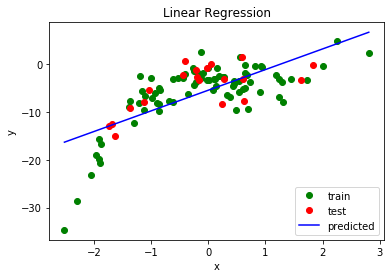

Saving figure Linear Regression
train mean squares error: 20.94130294527603
test mean squared error: 15.918648866996486


<Figure size 432x288 with 0 Axes>

In [0]:
linear_model = linear_regression(X_train_simple, y_train_simple)
eval_model(linear_model, X_train_simple, y_train_simple, X_test_simple, y_test_simple, 'Linear Regression')

### *Train Simple Polynomial Model*

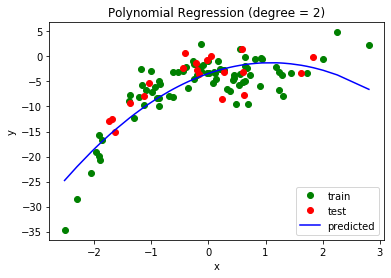

Saving figure Polynomial Regression (degree = 2)
train mean squares error: 12.80887195147668
test mean squared error: 10.672775392445219
____________________________________________________________


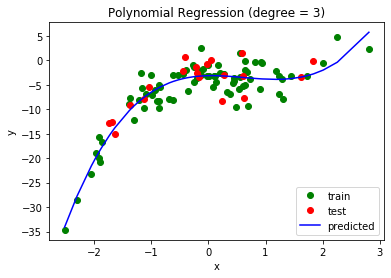

Saving figure Polynomial Regression (degree = 3)
train mean squares error: 6.03601865631432
test mean squared error: 6.683160377199995
____________________________________________________________


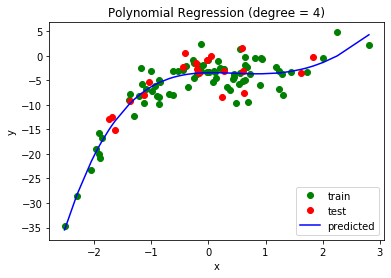

Saving figure Polynomial Regression (degree = 4)
train mean squares error: 5.907539356962651
test mean squared error: 6.605792759488469
____________________________________________________________


<Figure size 432x288 with 0 Axes>

In [0]:
for i in range(2, 5):
  poly_model = polynomial_regression(degree=i, X=X_train_simple, y=y_train_simple)
  eval_model(poly_model, X_train_simple, y_train_simple, X_test_simple, y_test_simple, 'Polynomial Regression (degree = {})'.format(i))
  print('_' * 60)

# **Data Exploration**



## **Loading the Dataset**

### *Download the dataset*

In [0]:
!wget https://raw.githubusercontent.com/mostafaghadimi/IEEE-HandsOn/master/resources/data.csv

--2019-12-23 14:52:20--  https://raw.githubusercontent.com/mostafaghadimi/IEEE-HandsOn/master/resources/data.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1198118 (1.1M) [text/plain]
Saving to: ‘data.csv’

data.csv            100%[===================>]   1.14M  --.-KB/s    in 0.05s   

2019-12-23 14:52:20 (21.7 MB/s) - ‘data.csv’ saved [1198118/1198118]



### *Read csv File*

In [0]:
data_df = pd.read_csv('data.csv')
data_df.head()

,longitude,latitude,housingMedianAge,totalRooms,totalBedrooms,population,households,medianIncome,medianHouseValue
0,-120.18,36.59,25.0,948.0,198.0,613.0,171.0,2.3026,90.6
1,-122.70,38.45,26.0,2011.0,557.0,855.0,530.0,1.1250,233.3
2,-117.93,33.83,32.0,1792.0,411.0,1131.0,381.0,2.4942,186.3
3,-118.27,33.96,34.0,1040.0,276.0,1083.0,255.0,1.6467,90.9
4,-117.26,34.13,39.0,3521.0,747.0,2256.0,721.0,2.1375,87.5


## **Describe Data**


Generate descriptive statistics that summarize the central tendency,
dispersion and shape of a dataset's distribution, excluding
``NaN`` values.

In [0]:
data_df.describe()

,longitude,latitude,housingMedianAge,totalRooms,totalBedrooms,population,households,medianIncome,medianHouseValue
count,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.898014,1425.476744,499.539680,3.870671,206.855817
std,2.003532,2.135952,12.585558,2181.615252,421.247906,1132.462122,382.329753,1.899822,115.395616
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14.999000
25%,-121.800000,33.930000,18.000000,1447.750000,295.000000,787.000000,280.000000,2.563400,119.600000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179.700000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264.725000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500.001000


### *Extract Column Names*

In [0]:
column_names = list(data_df.columns)
column_names

['longitude',
 'latitude',
 'housingMedianAge',
 'totalRooms',
 'totalBedrooms',
 'population',
 'households',
 'medianIncome',
 'medianHouseValue']

In [0]:
x_names = column_names[:-1] # Select all columns except medianHouseValue
y_name = column_names[-1] # Select medianHouseValue Column
x_names, y_name

(['longitude',
  'latitude',
  'housingMedianAge',
  'totalRooms',
  'totalBedrooms',
  'population',
  'households',
  'medianIncome'],
 'medianHouseValue')

### *Read the Data*

In [0]:
X = data_df.drop(columns=[y_name])
y = data_df.drop(columns=x_names)
X.shape, y.shape

((20640, 8), (20640, 1))

In [0]:
X.head()

,longitude,latitude,housingMedianAge,totalRooms,totalBedrooms,population,households,medianIncome
0,-120.18,36.59,25.0,948.0,198.0,613.0,171.0,2.3026
1,-122.70,38.45,26.0,2011.0,557.0,855.0,530.0,1.1250
2,-117.93,33.83,32.0,1792.0,411.0,1131.0,381.0,2.4942
3,-118.27,33.96,34.0,1040.0,276.0,1083.0,255.0,1.6467
4,-117.26,34.13,39.0,3521.0,747.0,2256.0,721.0,2.1375


In [0]:
y.head()

,medianHouseValue
0,90.6
1,233.3
2,186.3
3,90.9
4,87.5


## **Data Splitting**

### *Count the samples*

In [0]:
samples_count = len(X)
samples_count

20640

### *Split Test Data*

In [0]:
test_size = 0.1
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)

In [0]:
X_train.head()

,longitude,latitude,housingMedianAge,totalRooms,totalBedrooms,population,households,medianIncome
7064,-118.48,34.03,32.0,1793.0,476.0,1143.0,448.0,2.8981
11341,-122.08,40.64,14.0,3099.0,519.0,1447.0,494.0,4.0132
8250,-119.01,35.39,29.0,1820.0,459.0,1134.0,419.0,1.8289
13690,-118.49,34.26,25.0,8389.0,1872.0,4483.0,1747.0,3.5497
1416,-118.19,33.78,42.0,1021.0,300.0,533.0,187.0,1.8036


In [0]:
y_train.head()

,medianHouseValue
7064,353.6
11341,141.2
8250,59.4
13690,261.3
1416,175.0


In [0]:
X_test.head()

,longitude,latitude,housingMedianAge,totalRooms,totalBedrooms,population,households,medianIncome
3964,-117.46,34.08,18.0,3830.0,750.0,2767.0,702.0,3.6602
183,-117.90,33.74,25.0,808.0,163.0,1066.0,189.0,4.7679
18951,-122.47,38.60,20.0,1036.0,202.0,589.0,194.0,5.3698
5226,-117.18,34.07,7.0,1347.0,301.0,799.0,276.0,2.9485
213,-119.09,36.22,34.0,1715.0,290.0,780.0,297.0,3.4306


In [0]:
y_test.head()

,medianHouseValue
3964,120.7
183,173.1
18951,303.3
5226,112.5
213,74.3


### *Feature Scaling*

Machine Learning algorithms don’t perform well when
the input numerical attributes have very different scales. 


There are two common ways to get all attributes to have the same scale: min-max
scaling and standardization.

* **Min-max scaling (Normalization):** Values are
shifted and rescaled so that they end up ranging from 0 to 1. We do this by subtract‐
ing the min value and dividing by the max minus the min. 


* **Standardization:** First it subtracts the mean value (so standardized
values always have a zero mean), and then it divides by the standard deviation so that
the resulting distribution has unit variance. 

* **Difference:** Standardization is much less affected by outliers. For example, suppose a district
had a median income equal to 100 (by mistake). Min-max scaling would then crush
all the other values from 0–15 down to 0–0.15, whereas standardization would not be much affected. 

In [0]:
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), index=X_train.index, columns=X_train.columns)
X_test = pd.DataFrame(scaler.transform(X_test), index=X_test.index, columns=X_test.columns)
X_train.mean(), X_train.std(), X_test.mean(), X_test.std()

(longitude           1.224413e-15
 latitude            5.301665e-16
 housingMedianAge   -3.228423e-16
 totalRooms         -3.574038e-18
 totalBedrooms       6.617350e-17
 population         -7.495918e-17
 households         -2.220924e-17
 medianIncome       -1.414315e-16
 dtype: float64, longitude           1.000027
 latitude            1.000027
 housingMedianAge    1.000027
 totalRooms          1.000027
 totalBedrooms       1.000027
 population          1.000027
 households          1.000027
 medianIncome        1.000027
 dtype: float64, longitude           0.036296
 latitude           -0.039594
 housingMedianAge    0.015892
 totalRooms         -0.001539
 totalBedrooms      -0.013626
 population         -0.020431
 households         -0.011842
 medianIncome        0.001647
 dtype: float64, longitude           1.003358
 latitude            1.008058
 housingMedianAge    1.011645
 totalRooms          0.949259
 totalBedrooms       0.947394
 population          0.911778
 households         

In [0]:
X_train.head()

,longitude,latitude,housingMedianAge,totalRooms,totalBedrooms,population,households,medianIncome
7064,0.547736,-0.754570,0.268918,-0.384542,-0.147549,-0.249372,-0.135358,-0.511884
11341,-1.249801,2.342788,-1.162982,0.211131,-0.045995,0.016802,-0.015606,0.075205
8250,0.283099,-0.117292,0.030268,-0.372227,-0.187699,-0.257252,-0.210855,-1.074806
13690,0.542743,-0.646795,-0.287932,2.623924,3.149431,2.675043,3.246354,-0.168823
1416,0.692538,-0.871717,1.064418,-0.736655,-0.563214,-0.783472,-0.814825,-1.088126


In [0]:
X_test.head()

,longitude,latitude,housingMedianAge,totalRooms,totalBedrooms,population,households,medianIncome
3964,1.057039,-0.731141,-0.844782,0.544543,0.499566,1.172559,0.525885,-0.110646
183,0.837340,-0.890460,-0.287932,-0.833805,-0.886772,-0.316791,-0.809618,0.472546
18951,-1.444534,1.386871,-0.685682,-0.729813,-0.794664,-0.734440,-0.796602,0.789440
5226,1.196847,-0.735827,-1.719833,-0.587965,-0.560853,-0.550570,-0.583130,-0.485348
213,0.243154,0.271634,0.428018,-0.420118,-0.586832,-0.567205,-0.528460,-0.231528


## **Exploration**

### *Plot all `x-y` relations*

Target $variable (y)$ might have a significant relation with some features.

For example, according to the following plots, it seems that the medianHouseValue is much more related to the medianIncome than the other features.



Saving figure Housing-Price-Attributes


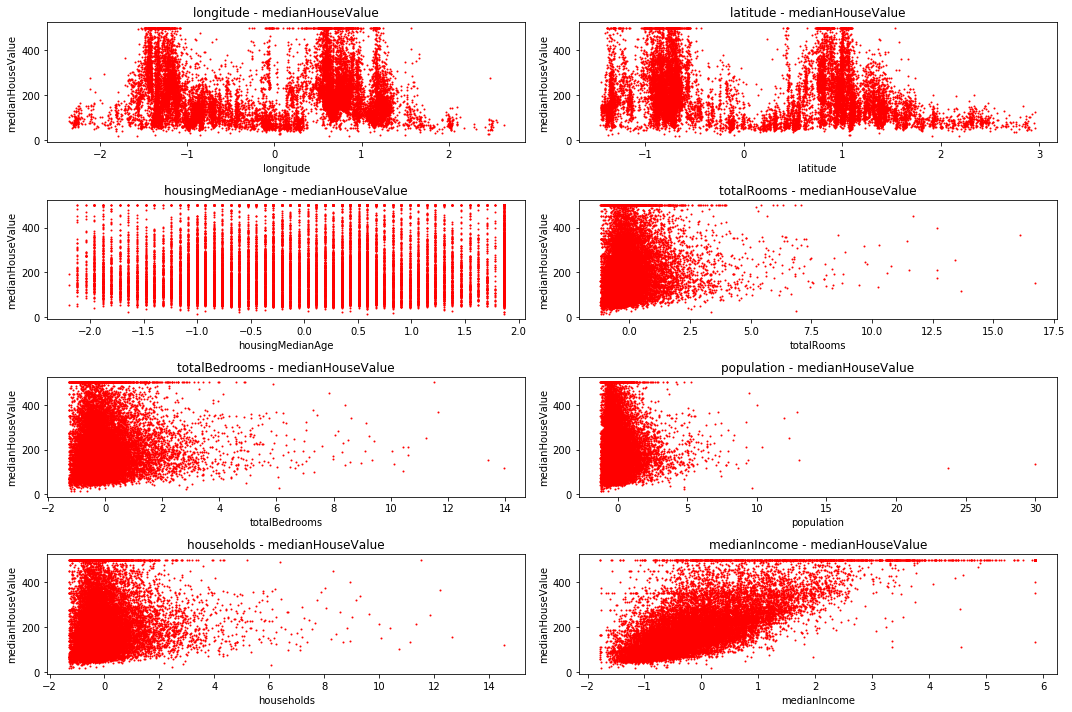

In [0]:
plt.figure(figsize=(15, 10))

for position, x_name in enumerate(x_names):

    plt.subplot(4, 2, position + 1)
    plot = plt.plot(X_train[x_name], y_train, 'ro')
    plt.setp(plot, ms=1)
    
    plt.title(x_name + ' - ' + y_name)
    plt.xlabel(x_name)
    plt.ylabel(y_name)
    
save_fig("Housing-Price-Attributes")
plt.show()

## **Correlations**

### *Correlation Matrix*

Since the dataset is not too large, you can easily compute the standard correlation coefficient (also called Pearson’s r) between every pair of attributes using the `corr()` method: 

\begin{align}
corr_{xy} = \frac{\Sigma(x_i - \bar{x})(y_i - \bar{y})}
{\sqrt{\Sigma(x_i - \bar{x})^{2} \Sigma(y_i - \bar{y})^{2}}}
\end{align}

In [0]:
corr_matrix = data_df.corr()
corr_matrix

,longitude,latitude,housingMedianAge,totalRooms,totalBedrooms,population,households,medianIncome,medianHouseValue
longitude,1.000000,-0.924664,-0.108197,0.044568,0.068378,0.099773,0.055310,-0.015176,-0.045967
latitude,-0.924664,1.000000,0.011173,-0.036100,-0.066318,-0.108785,-0.071035,-0.079809,-0.144160
housingMedianAge,-0.108197,0.011173,1.000000,-0.361262,-0.320485,-0.296244,-0.302916,-0.119034,0.105623
totalRooms,0.044568,-0.036100,-0.361262,1.000000,0.929893,0.857126,0.918484,0.198050,0.134153
totalBedrooms,0.068378,-0.066318,-0.320485,0.929893,1.000000,0.878026,0.979829,-0.008093,0.050594
population,0.099773,-0.108785,-0.296244,0.857126,0.878026,1.000000,0.907222,0.004834,-0.024650
households,0.055310,-0.071035,-0.302916,0.918484,0.979829,0.907222,1.000000,0.013033,0.065843
medianIncome,-0.015176,-0.079809,-0.119034,0.198050,-0.008093,0.004834,0.013033,1.000000,0.688075
medianHouseValue,-0.045967,-0.144160,0.105623,0.134153,0.050594,-0.024650,0.065843,0.688075,1.000000


The correlation coefficient ranges from $–1$ to $1$. When it is close to $1$, it means that there is a strong **positive correlation**;
* for example, the median house value tends to go up when the median income goes up.

When the coefficient is close to $–1$, it means that there is a strong negative correlation;
* You can see a small negative correlation between the latitude and the median house value (i.e., prices have a slight tendency to go down when you go north).

Finally, coefficients close to zero mean that there is no linear correlation. Figure below shows various plots along with the correlation coefficient between their horizontal and vertical axes.

![Correlation](https://upload.wikimedia.org/wikipedia/commons/thumb/d/d4/Correlation_examples2.svg/1012px-Correlation_examples2.svg.png)

### *Plot Correlation Matrix*

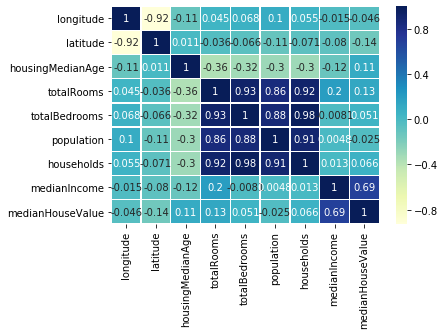

In [0]:
sns.heatmap(corr_matrix, 
            cmap = 'YlGnBu',
            annot = True,
            linewidths = .3,
            linecolor = 'white'
           )

According to the correlation values, we face with 4 categories of features:

- `latitude` and `longitude` are correlated closely (-0.92), but they aren't correlated with the target variable.

- `houseMeidanAge` is correlated with neither rest of features nor the target variable.

- `totalRooms`, `totalBedrooms`, `population` and `households` are correlated with each other closely. Though, they aren't correlated with the target variable.

- `medianIncome` isn't correlated with the rest of the features. It's the only feature that correlated with the target variable (0.69).


# **PCA**

Principal component analysis is a statistical procedure that uses an orthogonal transformation to convert a set of observations of possibly correlated variables into a set of values of linearly uncorrelated variables called principal components.

## *Calculate Principal Components*

In [0]:
n_components = X_train.shape[1]
pca = PCA(n_components=n_components)
X_train_PCA = pd.DataFrame(pca.fit_transform(X_train), index=X_train.index, columns=list(['PC' + str(x + 1) for x in range(n_components)]))
X_train_PCA.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8
7064,-0.422877,-0.945501,-0.578238,-0.020112,-0.069765,-0.193832,-0.061901,-0.007411
11341,0.060028,2.511421,0.650114,-1.125663,0.018717,0.512620,0.432154,-0.074610
8250,-0.518548,-0.303726,-0.947984,-0.515653,-0.085667,0.030594,-0.003540,-0.021176
13690,5.820810,-0.150377,-0.845952,0.732785,-0.218407,-0.283953,0.187894,-0.046791
1416,-1.559926,-1.208381,-1.266196,0.275690,-0.233948,0.030328,-0.226594,0.119730


## *Correlations*

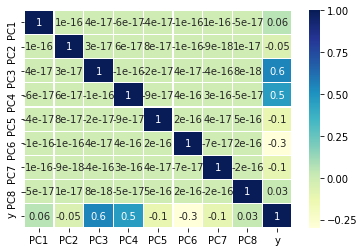

In [0]:
sns.heatmap(X_train_PCA.assign(y = y_train).corr(), 
            cmap = 'YlGnBu',
            annot = True,
            linewidths = .3,
            linecolor = 'white',
            fmt='.1g'
           )

As it is obvious, each pair of PCs is almost not linearly correlated. In addition, the correlations of PC3 and PC4 with the target variable are significant.


## *Calculate their Variances*

In [0]:
for i in range(1, n_components + 1):
    pc_name = 'PC' + str(i)
    print("Variance of " + pc_name + ": " + str(np.var(X_train_PCA[pc_name])))

Variance of PC1: 3.9041824828572804
Variance of PC2: 1.9062598988880013
Variance of PC3: 1.0719360509914917
Variance of PC4: 0.8259443386965624
Variance of PC5: 0.14725064675958788
Variance of PC6: 0.08194866640807258
Variance of PC7: 0.04746034171146172
Variance of PC8: 0.015017573687513924


The variance of first four PCs should the considered while the others are almost negligible. So we can ignore the negligible variances.

## *PCA with 4 components*

In [0]:
n_components = 4
pca = PCA(n_components=n_components)
columns = ['PC' + str(x + 1) for x in range(n_components)]
X_train_PCA = pd.DataFrame(pca.fit_transform(X_train), index=X_train.index, columns=columns)
X_train_PCA.head()

,PC1,PC2,PC3,PC4
7064,-0.422877,-0.945501,-0.578238,-0.020112
11341,0.060028,2.511421,0.650114,-1.125663
8250,-0.518548,-0.303726,-0.947984,-0.515653
13690,5.820810,-0.150377,-0.845952,0.732785
1416,-1.559926,-1.208381,-1.266196,0.275690


## *Plot all PC - y relations*

Saving figure Housing-Price-PC


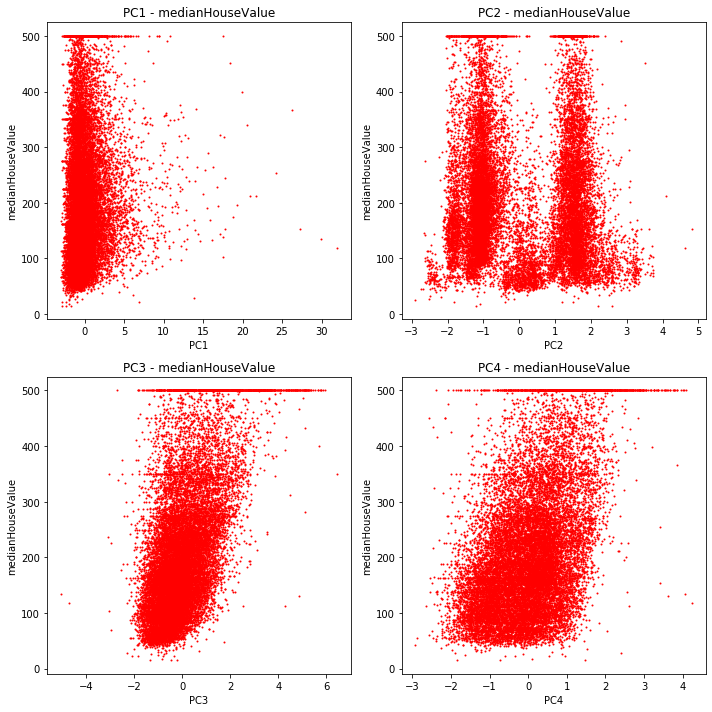

In [0]:
plt.figure(figsize=(10, 10))

for position, pc_name in enumerate(list(X_train_PCA.columns)):
  plt.subplot(2, 2, position + 1)
  plot = plt.plot(X_train_PCA[pc_name], y_train, 'ro')
  plt.setp(plot, ms=1)
  plt.title(pc_name + ' - ' + y_name)
  plt.xlabel(pc_name)
  plt.ylabel(y_name)

save_fig("Housing-Price-PC")
plt.show()

## *Transform `X_test` for later usage*

In [0]:
X_test_PCA = pd.DataFrame(pca.transform(X_test), index=X_test.index, columns=list(['PC' + str(x + 1) for x in range(n_components)]))
X_test_PCA.head()

,PC1,PC2,PC3,PC4
3964,1.636730,-1.124199,-0.030235,-0.554503
183,-1.171205,-1.413412,0.623697,-0.287011
18951,-1.517301,1.769677,1.264074,-0.593489
5226,-0.606101,-1.499108,0.306386,-1.936156
213,-1.122818,-0.083768,-0.235374,0.058469


# **Linear Models**

More generally, a linear model makes a prediction by simply computing a weighted sum of the input features, plus a constant called the bias term (also called the intercept term), as shown in equation below:

![alt text](https://wikimedia.org/api/rest_v1/media/math/render/svg/704b31aa61dfc93d672f15bf02aa6d168be49643)

where $^T$ denotes the transpose, so that $x_i^Tβ$ is the inner product between vectors $x_i$ and $β$.

## *Normal Equation*

To find the value of $θ$ that minimizes the cost function, there is a closed-form solution — in other words, a mathematical equation that gives the result directly. This is called the Normal Equation.

\begin{align}
\theta = (X^{T}X)^{-1}X^{T}y
\end{align}

### *Prepare Matrices*

#### *Copy X before editing it*

In [0]:
XM = X_train_PCA.copy()
XM.head()

,PC1,PC2,PC3,PC4
7064,-0.422877,-0.945501,-0.578238,-0.020112
11341,0.060028,2.511421,0.650114,-1.125663
8250,-0.518548,-0.303726,-0.947984,-0.515653
13690,5.820810,-0.150377,-0.845952,0.732785
1416,-1.559926,-1.208381,-1.266196,0.275690


#### *Add column $X_0 = 1$ for bias*

In [0]:
XM.insert(loc=0, column='X0', value=1) # XM represents the weights + bias matrix
XM.head()

,X0,PC1,PC2,PC3,PC4
7064,1,-0.422877,-0.945501,-0.578238,-0.020112
11341,1,0.060028,2.511421,0.650114,-1.125663
8250,1,-0.518548,-0.303726,-0.947984,-0.515653
13690,1,5.820810,-0.150377,-0.845952,0.732785
1416,1,-1.559926,-1.208381,-1.266196,0.275690


#### *Same for `X_test`*

In [0]:
XM_test = X_test_PCA.copy()
XM_test.insert(loc=0, column='X0', value=1)
XM_test.head()

,X0,PC1,PC2,PC3,PC4
3964,1,1.636730,-1.124199,-0.030235,-0.554503
183,1,-1.171205,-1.413412,0.623697,-0.287011
18951,1,-1.517301,1.769677,1.264074,-0.593489
5226,1,-0.606101,-1.499108,0.306386,-1.936156
213,1,-1.122818,-0.083768,-0.235374,0.058469


#### *Prepare y*

In [0]:
yM = y_train.copy()
yM.head()

,medianHouseValue
7064,353.6
11341,141.2
8250,59.4
13690,261.3
1416,175.0


#### *Same for `y_test`*

In [0]:
yM_test = y_test.copy()
yM_test.head()

,medianHouseValue
3964,120.7
183,173.1
18951,303.3
5226,112.5
213,74.3


#### *Convert to numpy*

In [0]:
XM = XM.to_numpy()
XM_test = XM_test.to_numpy()
yM = yM.to_numpy()
yM_test = yM_test.to_numpy()
XM.shape, yM.shape, XM_test.shape, yM_test.shape

((18576, 5), (18576, 1), (2064, 5), (2064, 1))

### *Train*

In [0]:
XTX = np.dot(XM.T, XM)
XTXinv = np.linalg.pinv(XTX)
XTy = np.dot(XM.T, yM)
theta = np.dot(XTXinv, XTy)
theta

array([[206.75431546],
       [  3.51999807],
       [ -4.28391772],
       [ 61.44499034],
       [ 58.30201237]])

### **Evaluate**

#### *Make predictions*

In [0]:
prediction_train = np.dot(XM, theta)
prediction_test = np.dot(XM_test, theta)
prediction_train.shape, prediction_test.shape

((18576, 1), (2064, 1))

#### *Plot train predictions*

Saving figure Housing-Price-Linear-Trainset.png


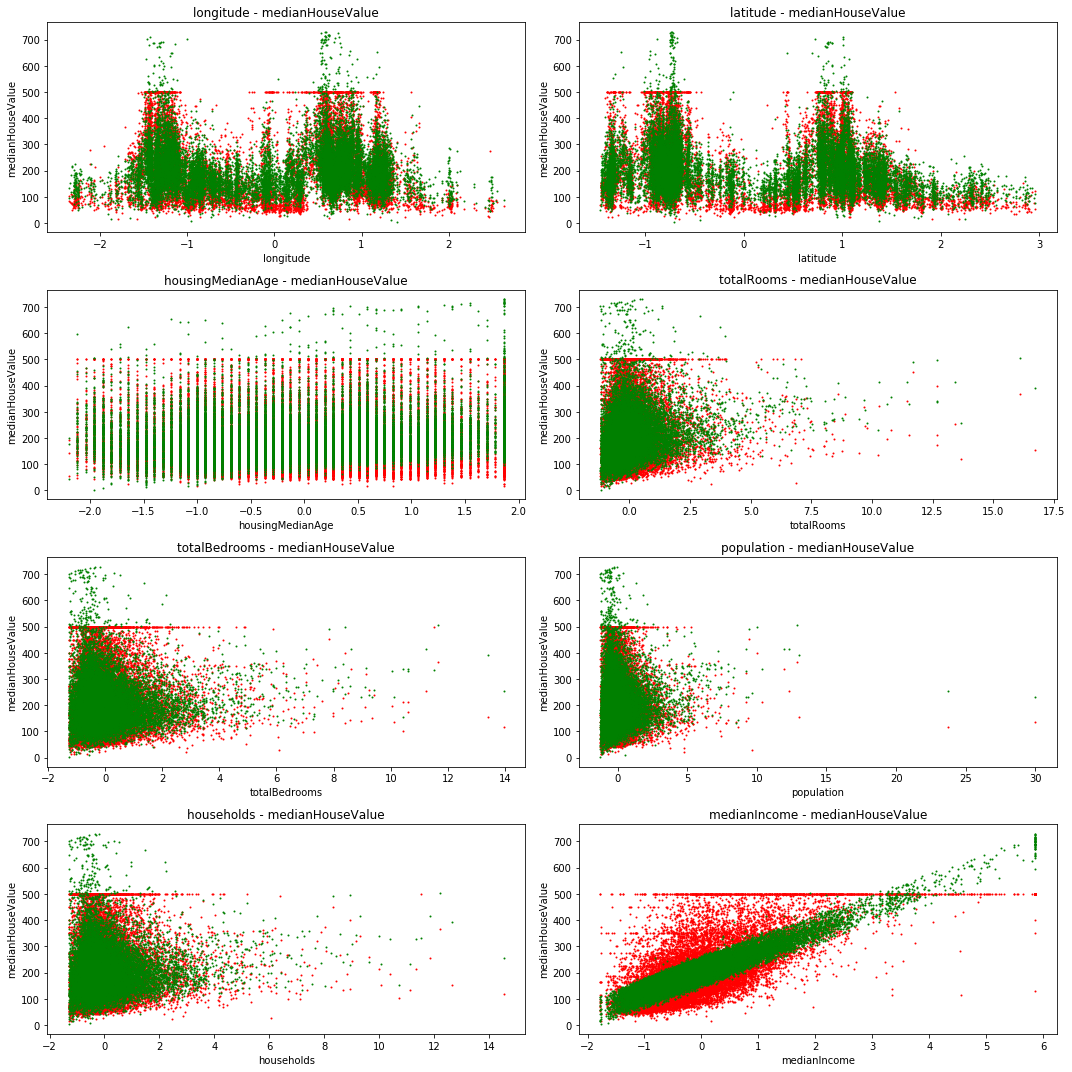

In [0]:
plt.figure(figsize=(15, 15))

for position, x_name in enumerate(x_names):
    plt.subplot(4, 2, position + 1)
    plot = plt.plot(X_train[x_name], y_train, 'ro')
    plt.setp(plot, ms=1)
    plot = plt.plot(X_train[x_name], prediction_train, 'go')
    plt.setp(plot, ms=1)
    plt.title(x_name + ' - ' + y_name)
    plt.xlabel(x_name)
    plt.ylabel(y_name)

save_fig("Housing-Price-Linear-Trainset.png")
plt.show()

#### *Plot test predictions*

Saving figure Housing-Price-Linear-Testset.png


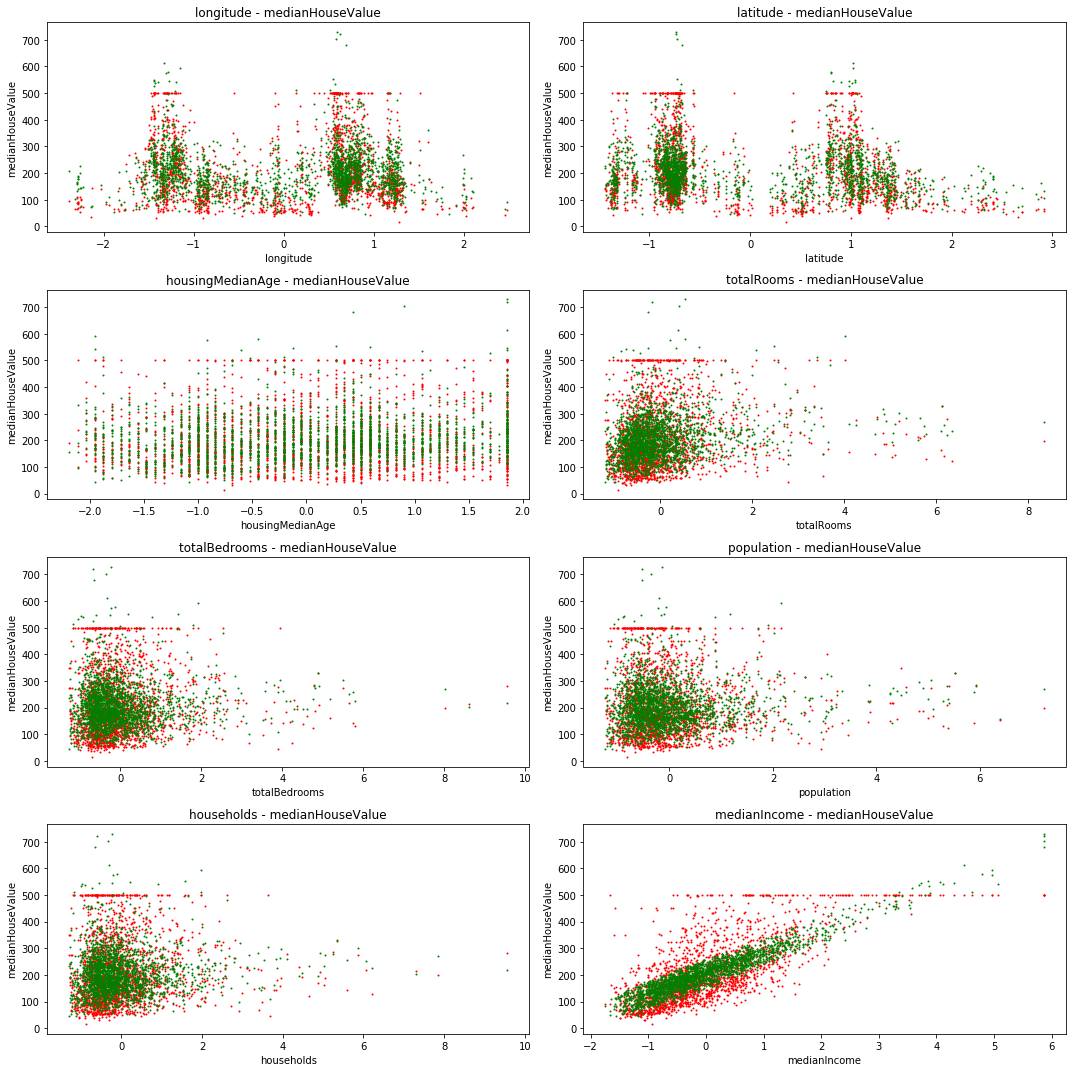

In [0]:
plt.figure(figsize=(15, 15))

for position, x_name in enumerate(x_names):
    plt.subplot(4, 2, position + 1)
    plot = plt.plot(X_test[x_name], y_test, 'ro')
    plt.setp(plot, ms=1)
    plot = plt.plot(X_test[x_name], prediction_test, 'go')
    plt.setp(plot, ms=1)
    plt.title(x_name + ' - ' + y_name)
    plt.xlabel(x_name)
    plt.ylabel(y_name)

save_fig("Housing-Price-Linear-Testset.png")
plt.show()

#### *MSE*

In [0]:
mean_squared_error(y_train, prediction_train)

6349.777649757421

In [0]:
mean_squared_error(y_test, prediction_test)

6221.896698943166

## **Gradient Descent**

*Gradient Descent* is a very generic optimization algorithm capable of finding optimal solutions to a wide range of problems. The general idea of Gradient Descent is to tweak parameters iteratively in order to **minimize** a cost function. Concretely, you start by filling $θ$ with random values (this is called *random initialization*), and then you improve it gradually, taking one baby step at a time, each step attempting to decrease the cost function (e.g., the MSE), until the algorithm converges to a minimum.

\begin{align}
    cost=\frac{1}{2m}\Sigma_{i=1}^{m}(h_\theta(x)-y)^2
\end{align}

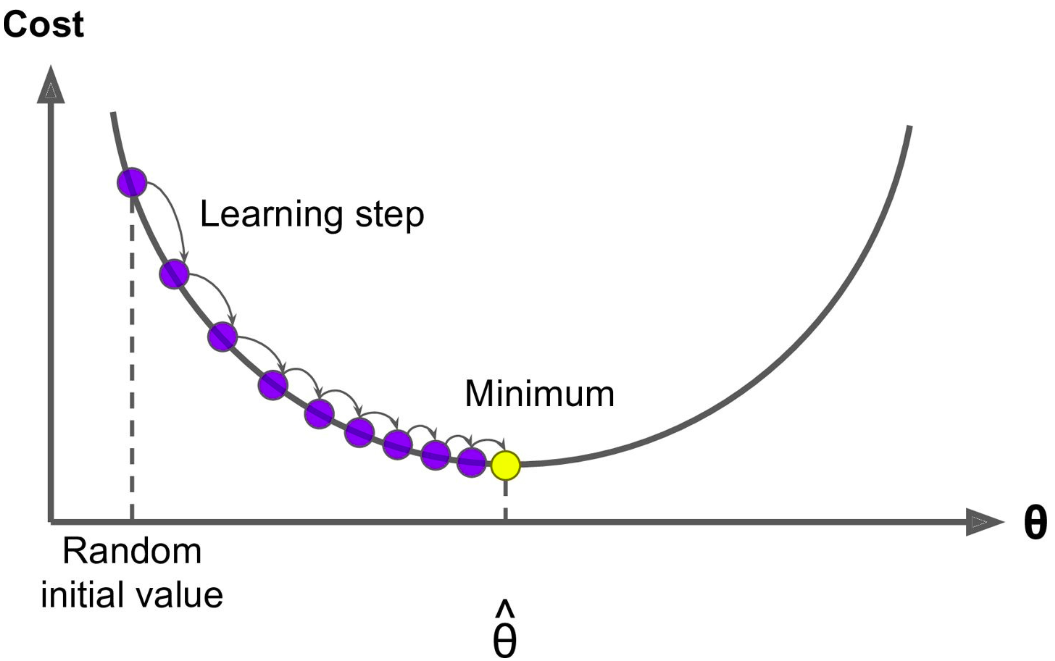

In [0]:
def calc_cost(prediction, y):
    return np.sum((prediction - y) ** 2) / (2 * len(y))

### *Batch Gradient Descent*

\begin{align}
    gradients=\frac{2}{m}X^T.(h_\theta(x)-y)
\end{align}

This formula involves calculations over the full training set $X$, at each Gradient Descent step! This is why the algorithm is called Batch Gradient Descent:
* it uses the whole batch of training data at every step. As a result it is terribly slow on very large training sets (but we will see much faster Gradient Descent algorithms shortly). However, Gradient Descent scales well with the number of features; training a Linear Regression model when there are hundreds of thousands of features is much faster using Gradient Descent than using the Normal Equation.

#### Define the Learning Rate and number of iterations

In [0]:
iterations = 1000
lr = 1e-2

#### Initialize weights and list of costs

In [0]:
theta = np.random.randn(XM.shape[1],1)
costs = []

#### Train

In [0]:
for iteration in tqdm(range(iterations)):
    prediction = np.dot(XM, theta)
    costs.append(calc_cost(prediction, yM))
    gradients = 2. / len(XM) * np.dot(XM.T, prediction - yM)
    theta = theta - lr * gradients
theta

100%|██████████| 1000/1000 [00:00<00:00, 5464.73it/s]


array([[206.75431511],
       [  3.51999807],
       [ -4.28391772],
       [ 61.44499032],
       [ 58.30200888]])

#### Plot cost for each iteration

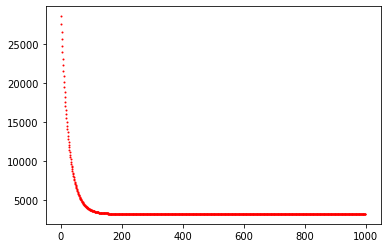

In [0]:
plot = plt.plot(list(range(iterations)), costs, 'ro')
plt.setp(plot, ms=1)
plt.show()

### *Stochastic Gradient Descent (Optional)*

The main problem with *Batch Gradient Descent* is the fact that it uses the whole training set to compute the gradients at every step, which makes it very slow when the training set is large. At the opposite extreme, **Stochastic Gradient Descent** just picks a random instance in the training set at every step and computes the gradients based only on that single instance.

Obviously this makes the algorithm much faster since it has very little data to manipulate at every iteration. It also makes it possible to train on huge training sets, since only one instance needs to be in memory at each iteration.

#### Define number of iterations and Learning Schedule

In [0]:
iterations = 100

t0, t1 = 5, 50 # learning schedule hyperparameters

def learning_schedule(t): 
    return t0 / (t + t1)

#### Initialize weights and list of costs

In [0]:
theta = np.random.randn(XM.shape[1],1)
costs = []

#### Train

In [0]:
for iteration in tqdm(range(iterations)): 
    for i in range(len(XM)):
        random_index = np.random.randint(len(XM))
        xi = XM[random_index:random_index+1]
        yi = yM[random_index:random_index+1]
        gradients = 2 * np.dot(xi.T, np.dot(xi, theta) - yi)
        eta = learning_schedule(iteration * len(XM) + i)
        theta = theta - eta * gradients
    costs.append(calc_cost(np.dot(XM, theta), yM))
theta

100%|██████████| 100/100 [00:37<00:00,  2.58it/s]


array([[206.76835668],
       [  3.49869211],
       [ -4.29729736],
       [ 61.45451794],
       [ 58.13886162]])

#### Plot cost for each iteration

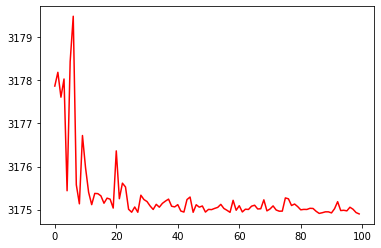

In [0]:
plot = plt.plot(list(range(iterations)), costs, 'r')
plt.setp(plot, ms=1)
plt.show()

# **Polynomial Models**

## *Train polynomial models for degrees 1 to 7*

Clearly, a straight line will never fit this data properly. So let’s use Scikit-Learn’s `PolynomialFeatures` class to transform our training data.

In [0]:
degree_list = list(range(1, 8))

train_mses = []
test_mses = []
for degree in tqdm(degree_list):
  model = polynomial_regression(degree, X_train_PCA, y_train)
  train_prediction = model.predict(X_train_PCA)
  test_prediction = model.predict(X_test_PCA)
  train_mses.append(mean_squared_error(train_prediction, y_train))
  test_mses.append(mean_squared_error(test_prediction, y_test))

len(train_mses), len(test_mses)

100%|██████████| 7/7 [00:02<00:00,  2.25it/s]


(7, 7)

## *Degree v.s. MSE*

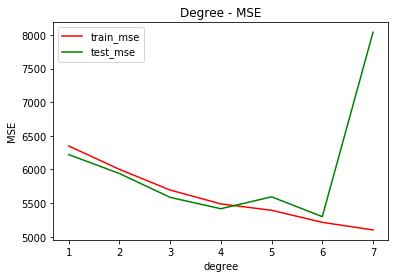

In [0]:
plt.plot(degree_list, train_mses, 'r', label='train_mse')
plt.plot(degree_list, test_mses, 'g', label = 'test_mse')
plt.xlabel('degree')
plt.ylabel('MSE')
plt.legend(loc='upper left')
plt.title('Degree - MSE')
plt.show()

# **Regularized Regression**

A good way to reduce *overfitting* is to regularize the model (i.e., to constrain it):
* the fewer degrees of freedom it has, the harder it will be for it to overfit the data. For example, a simple way to regularize a polynomial model is to reduce the number of polynomial degrees.

* For a linear model, regularization is typically achieved by constraining the weights of the model. We will now look at *Ridge Regression*, *Lasso Regression*, and *Elastic Net*, which implement three different ways to constrain the weights.

**Ridge Regression** (also called Tikhonov regularization) is a regularized version of Linear Regression: a regularization term equal to $\alpha\sum{_{i=1} ^n \theta_i^2}$ is added to the cost function. 

This forces the learning algorithm to not only fit the data but also keep the model weights as small as possible. Note that the regularization term should only be added to the cost function during training. Once the model is trained, you want to evaluate the model’s performance using the unregularized performance measure. 

In [0]:
def train_predict_ridge():
  
  model = Ridge(alpha=1, solver="cholesky")
  model.fit(X_train_PCA, y_train)

  train_prediction = model.predict(X_train_PCA)
  test_prediction = model.predict(X_test_PCA)

  return train_prediction, test_prediction

Least Absolute Shrinkage and Selection Operator Regression (simply called **Lasso Regression**) is another regularized version of Linear Regression: just like Ridge Regression, it adds a regularization term to the cost function, but it uses the $ℓ_1$ norm of the weight vector instead of half the square of the $ℓ_2$ norm.

\begin{align}
    J(\theta) = MSE(\theta) + \alpha\sum{_{i=1} ^n |\theta_i|}
\end{align}

In [0]:
def train_predict_ridge():
  
  model = Lasso(alpha=0.1)
  model.fit(X_train_PCA, y_train)

  train_prediction = model.predict(X_train_PCA)
  test_prediction = model.predict(X_test_PCA)

  return train_prediction, test_prediction

**Elastic Net** is a middle ground between Ridge Regression and Lasso Regression. The regularization term is a simple mix of both Ridge and Lasso’s regularization terms, and you can control the mix ratio r. When $r = 0$, Elastic Net is equivalent to Ridge Regression, and when $r = 1$, it is equivalent to Lasso Regression.

\begin{align}
    J(\theta) = MSE(\theta) + r\alpha\sum{_{i=1} ^n |\theta_i|} + \frac{1-r} {2} \alpha\sum{_{i=1} ^n \theta_i^2}
\end{align}

In [0]:
def train_predict_ridge():
  
  model = ElasticNet(alpha=0.1, l1_ratio=0.5)
  model.fit(X_train_PCA, y_train)

  train_prediction = model.predict(X_train_PCA)
  test_prediction = model.predict(X_test_PCA)

  return train_prediction, test_prediction

# **Generalized Linear Model**



## *Introduction*

Ordinary linear regression predicts the expected value of a given unknown quantity (the response variable, a random variable) as a linear combination of a set of observed values (predictors). This implies that a constant change in a predictor leads to a constant change in the response variable (i.e. a linear-response model).

However, these assumptions are inappropriate for some types of response variables. For example, in cases where the response variable is expected to be always positive and varying over a wide range, constant input changes lead to geometrically varying, rather than constantly varying, output changes.

Generalized linear models cover all these situations by allowing for response variables that have arbitrary distributions (rather than simply normal distributions), and for an arbitrary function of the response variable (the link function) to vary linearly with the predicted values (rather than assuming that the response itself must vary linearly).


## *Overview*

In a Generalized Linear Model (GLM), each outcome Y of the dependent variables is assumed to be generated from a particular distribution in an exponential family.

## *Distributions*

- Gaussian regression
- Poisson regression
- Binomial regression (classification)
- Quasibinomial regression
- Multinomial classification
- Gamma regression
- Ordinal regression
- Negative Binomial regression
- Tweedie distribution


$$\begin{align}
E(Y) = \mu = g^{-1}(X\beta) \\
\end{align}$$

where E(Y) is the expected value of Y; Xβ is the linear predictor, a linear combination of unknown parameters β; g is the link function.

There are three components in generalized linear models.

1. Linear predictor

      > Linear Combination of params

2. Link function

 > Linear Model relate to the response variable (g)
3. Probability distribution

 > An exponential family of probability distributions
Why to use Generalized Linear Model (GLM)? The relationship between X and Y does not look linear. It’s more likely to be exponential. The variance of Y does not look constant with regard to X. Here, the variance of Y seems to increase when X increases. As Y represents the number of products, it always has to be a positive integer. In other words, Y is a discrete variable. However, the normal distribution used for linear regression assumes continuous variables. This also means the prediction by linear regression can be negative. It’s not appropriate for this kind of count data.

### **Logistic Regression**


**Logistic Regression** (also called Logit Regression) is commonly used to estimate the probability that an instance belongs to a particular class (e.g., what is the probability that this email is spam?). If the estimated probability is greater than $50\%$, then the model predicts that the instance belongs to that class (called the positive class, labeled $“1”$), or else it predicts that it does not (i.e., it belongs to the negative class, labeled $“0”$). This makes it a binary classifier.

In [0]:
iris = load_iris()
iris

{'DESCR': '.. _iris_dataset:\n\nIris plants dataset\n--------------------\n\n**Data Set Characteristics:**\n\n    :Number of Instances: 150 (50 in each of three classes)\n    :Number of Attributes: 4 numeric, predictive attributes and the class\n    :Attribute Information:\n        - sepal length in cm\n        - sepal width in cm\n        - petal length in cm\n        - petal width in cm\n        - class:\n                - Iris-Setosa\n                - Iris-Versicolour\n                - Iris-Virginica\n                \n    :Summary Statistics:\n\n    ============== ==== ==== ======= ===== ====================\n                    Min  Max   Mean    SD   Class Correlation\n    ============== ==== ==== ======= ===== ====================\n    sepal length:   4.3  7.9   5.84   0.83    0.7826\n    sepal width:    2.0  4.4   3.05   0.43   -0.4194\n    petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)\n    petal width:    0.1  2.5   1.20   0.76    0.9565  (high!)\n    ===========

In [0]:
cols = ['sepal_length','sepal_width', 'petal_length', 'petal_width']

X = iris.data
y = iris.target

df = pd.DataFrame(data=X, columns=cols)
df['target'] = y

df.head()

,sepal_length,sepal_width,petal_length,petal_width,target
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


In [0]:
species_map = {0: "setosa", 1: "versicolor", 2: "virginica"}
df['species_name'] = df['target'].map(species_map)
df.head()

,sepal_length,sepal_width,petal_length,petal_width,target,species_name
0,5.1,3.5,1.4,0.2,0,setosa
1,4.9,3.0,1.4,0.2,0,setosa
2,4.7,3.2,1.3,0.2,0,setosa
3,4.6,3.1,1.5,0.2,0,setosa
4,5.0,3.6,1.4,0.2,0,setosa


In [0]:
setosa = df['species_name'] == 'setosa'
df[setosa].describe()

,sepal_length,sepal_width,petal_length,petal_width,target
count,50.00000,50.000000,50.000000,50.000000,50.0
mean,5.00600,3.428000,1.462000,0.246000,0.0
std,0.35249,0.379064,0.173664,0.105386,0.0
min,4.30000,2.300000,1.000000,0.100000,0.0
25%,4.80000,3.200000,1.400000,0.200000,0.0
50%,5.00000,3.400000,1.500000,0.200000,0.0
75%,5.20000,3.675000,1.575000,0.300000,0.0
max,5.80000,4.400000,1.900000,0.600000,0.0


In [0]:
versicolor = df['species_name'] == 'versicolor'
df[versicolor].describe()

,sepal_length,sepal_width,petal_length,petal_width,target
count,50.000000,50.000000,50.000000,50.000000,50.0
mean,5.936000,2.770000,4.260000,1.326000,1.0
std,0.516171,0.313798,0.469911,0.197753,0.0
min,4.900000,2.000000,3.000000,1.000000,1.0
25%,5.600000,2.525000,4.000000,1.200000,1.0
50%,5.900000,2.800000,4.350000,1.300000,1.0
75%,6.300000,3.000000,4.600000,1.500000,1.0
max,7.000000,3.400000,5.100000,1.800000,1.0


In [0]:
virgnica = df['species_name'] == 'virginica'
df[virgnica].describe()

,sepal_length,sepal_width,petal_length,petal_width,target
count,50.00000,50.000000,50.000000,50.00000,50.0
mean,6.58800,2.974000,5.552000,2.02600,2.0
std,0.63588,0.322497,0.551895,0.27465,0.0
min,4.90000,2.200000,4.500000,1.40000,2.0
25%,6.22500,2.800000,5.100000,1.80000,2.0
50%,6.50000,3.000000,5.550000,2.00000,2.0
75%,6.90000,3.175000,5.875000,2.30000,2.0
max,7.90000,3.800000,6.900000,2.50000,2.0


In [0]:
log_reg = LogisticRegression()
log_reg.fit(iris["data"][:, 3:], (iris["target"] == 2).astype(np.int))

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

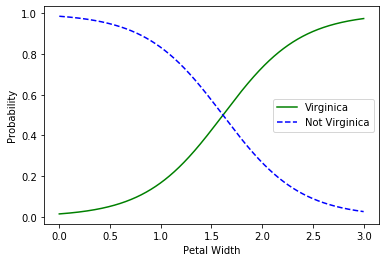

In [0]:
X_new = np.linspace(0, 3, 1000).reshape(-1, 1)
y_proba = log_reg.predict_proba(X_new)
plt.plot(X_new, y_proba[:, 1], "g-", label="Virginica")
plt.plot(X_new, y_proba[:, 0], "b--", label="Not Virginica")
plt.xlabel('Petal Width')
plt.ylabel('Probability')
plt.legend()
plt.show()

In [0]:

weights, interceptor = log_reg.coef_, log_reg.intercept_
weights, interceptor

(array([[2.61789264]]), array([-4.22209186]))

In [0]:
log_reg.predict([[1.8], [1.5]])


array([1, 0])